In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_prep import create_x_y_data

# Permutation Tests

In [2]:
from data_viz import histogram_plot

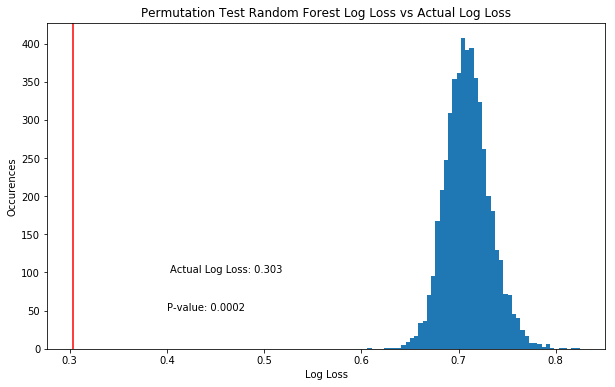

In [3]:
histogram_plot('rf_permutation_test.csv', 'Random Forest', 'log loss')

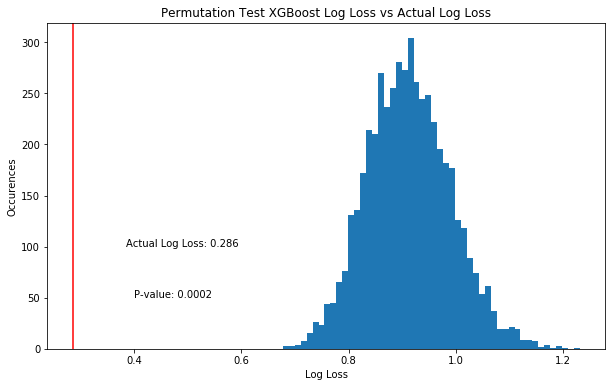

In [4]:
histogram_plot('xgb_permutation_test.csv', 'XGBoost', 'log loss')

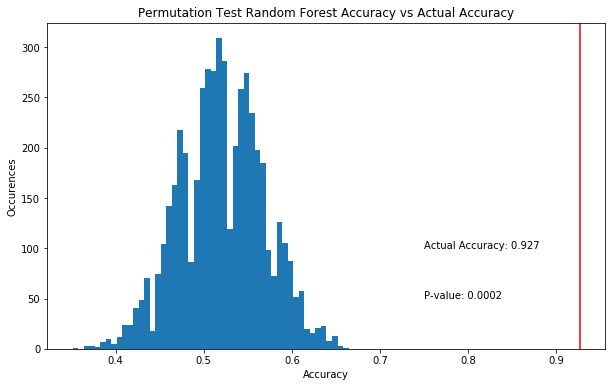

In [5]:
histogram_plot('rf_permutation_acc.csv', 'Random Forest', 'accuracy')

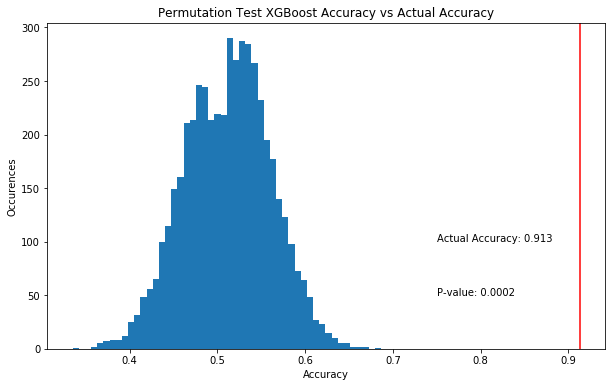

In [6]:
histogram_plot('xgb_permutation_acc.csv', 'XGBoost', 'accuracy')

### Data Prep

In [7]:
X_train, y_train, X_test, y_test, X, y = create_x_y_data()

In [8]:
print(X_train.shape)
X_test.shape

(93, 1984)


(44, 1984)

In [9]:
columns = X_train.columns

# Round 1 (Simple Train/Test Split)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

log_model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
log_model.fit(X_train, y_train)
y_pred = log_model.predict_proba(X_test)
log_model_ll = log_loss(y_test, y_pred)

lasso_mask = log_model.coef_ != 0
lasso_columns = columns[lasso_mask[0]]
print(f'Number of Features: {len(lasso_columns)}')
print(f'Lasso Log Loss: {log_model_ll}')

Number of Features: 88
Lasso Log Loss: 0.16907887125424767


In [11]:
from sklearn.ensemble import  RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=8, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)
rf_ll = log_loss(y_test, y_pred)

rf_mask = rf.feature_importances_ != 0
rf_columns = columns[rf_mask]
print(f'Number of Features: {len(rf_columns)}')
print(f'Random Forest Log Loss: {rf_ll}')

Number of Features: 1649
Random Forest Log Loss: 0.2970060960391264


In [12]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 700, random_state=8, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)
xgb_ll = log_loss(y_test, y_pred)

xgb_mask = xgb.feature_importances_ != 0
xgb_columns = columns[xgb_mask]
print(f'Number of Features: {len(xgb_columns)}')
print(f'XGBoost Log Loss: {xgb_ll}')

Number of Features: 241
XGBoost Log Loss: 0.18784231207841498


In [13]:
model_performance = pd.DataFrame({'Model': ['Lasso Regression', 'Random Forest', 'XGBoost'],
                   'Log Loss Performance': [round(log_model_ll, 3), round(rf_ll, 3), round(xgb_ll, 3)],
                   'Number of Weighted Features': [88, 1649, 241]})
model_performance

,Model,Log Loss Performance,Number of Weighted Features
0,Lasso Regression,0.169,88
1,Random Forest,0.297,1649
2,XGBoost,0.188,241


finding intersection of all three models

In [14]:
#gene names
round_1_important = set.intersection(set(lasso_columns), set(xgb_columns), set(rf_columns))
len(round_1_important)

34

In [15]:
# arg position to get the weights
round_1_mask = [x in round_1_important for x in columns]

In [16]:
# using the mask to get the weights of lasso beta coefficients
round_1_weights = log_model.coef_[0][round_1_mask]

In [17]:
# 34 features in xgb found important in the others
xgb_feat_importance = xgb.feature_importances_[round_1_mask]

In [18]:
round_1_df = pd.DataFrame({'Genes': list(round_1_important), 'Lasso Weights': round_1_weights,
                         'XGB Feature Importance': xgb_feat_importance})

In [20]:
round_1_df = round_1_df.sort_values('Lasso Weights')
round_1_df.head(20)

,Genes,Lasso Weights,XGB Feature Importance
23,ENSG00000120833.12,-0.207404,0.002494
29,ENSG00000225872.2,-0.177139,0.003741
3,ENSG00000214145.5,-0.162696,0.000623
31,ENSG00000203799.9,-0.151181,0.001247
17,ENSG00000271952.1,-0.123135,0.002494
20,ENSG00000165092.11,-0.118801,0.004364
24,ENSG00000232629.7,-0.095294,0.005611
12,ENSG00000183837.9,-0.088655,0.000623
6,ENSG00000165300.7,-0.084024,0.025561
9,ENSG00000167767.12,-0.062448,0.021820


In [21]:
len(set.intersection(set(xgb_columns), set(rf_columns)))

228

come back here... maybe figure out SHAP values or partial dependency plots...

# Round 2 (Kfold Validation)

Here we are doing kfold with X_train as X_. There are only 88 columns and with five kfolds there
is about 70 rows per fold

### Lasso

In [22]:
# copy X_train and y_train as X_ and y_ for kfold
X_ = X_train.copy()
y_ = y_train.copy()
X_.shape

(93, 1984)

In [25]:
from sklearn.model_selection import train_test_split, KFold

#lasso with kfold validation
log_model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
kf = KFold(n_splits=5, shuffle=True)

ll_performance = []
model_weights = []
#kfold split on X_ (which is X_train of len 110)
for train_index, test_index in kf.split(X_):
    X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
    log_model.fit(X_train, y_train)
    y_pred = log_model.predict_proba(X_test)
    log_ll = log_loss(y_test, y_pred)
    
    ll_performance.append(log_ll)
    model_weights.append(log_model.coef_)    

In [26]:
# note that this average perofmrance is terrible
display(ll_performance)

print(np.mean(ll_performance))

[0.1181088057847394,
 0.8386784714815425,
 0.27894852307789714,
 0.3413510075585735,
 0.03295560921512673]

0.3220084834235758


In [27]:
def important_gene_mask(columns, coefs):
    """
    inputs
    ------
    columns: columns of df
    coefs: beta weights of lasso
    
    results
    ------
    important_genes: name of genes with weight != 0
    gene_weights: beta weights of genes
    """
    
    mask = coefs[0] != 0
    
    gene_weights = coefs[0][mask]
    important_genes = columns[mask]

    return dict(zip(important_genes, gene_weights))

In [28]:
# find the genes with weight != 0 + their weights
l1_dict = important_gene_mask(columns, model_weights[0])
l2_dict = important_gene_mask(columns, model_weights[1])
l3_dict = important_gene_mask(columns, model_weights[2])
l4_dict = important_gene_mask(columns, model_weights[3])
l5_dict = important_gene_mask(columns, model_weights[4])

In [29]:
# find the genes found important in all five kfolds
lasso_gene_intersection = set.intersection(set(l1_dict.keys()), set(l2_dict.keys()), set(l3_dict.keys()),
                            set(l5_dict.keys()), set(l4_dict.keys()))
len(lasso_gene_intersection)

15

In [30]:
# find average weight for the 15 genes
lasso_average_weight = {}
for gene in lasso_gene_intersection:
    lasso_average_weight[gene] = l1_dict[gene]
    lasso_average_weight[gene] += l2_dict[gene]
    lasso_average_weight[gene] += l3_dict[gene]
    lasso_average_weight[gene] += l4_dict[gene]
    lasso_average_weight[gene] += l5_dict[gene]
    lasso_average_weight[gene] = lasso_average_weight[gene]/5
lasso_average_weight

{'ENSG00000250771.2': 0.025609744946210784,
 'ENSG00000232431.3': -0.02425101297804839,
 'ENSG00000120833.12': -0.06544009158075606,
 'ENSG00000156535.12': -0.09183079242996668,
 'ENSG00000164100.8': 0.055565160532281554,
 'ENSG00000078399.14': -0.13397331215128833,
 'ENSG00000188626.6': -0.10275140203977033,
 'ENSG00000267453.5': 0.09310823090861721,
 'ENSG00000230266.1': -0.03215541911613779,
 'ENSG00000259207.6': -0.054620039865596694,
 'ENSG00000165092.11': -0.052371361116496276,
 'ENSG00000079102.15': 0.05185684169690778,
 'ENSG00000164659.13': -0.11530516794600007,
 'ENSG00000248334.5': -0.05440614888991294,
 'ENSG00000260182.1': 0.13004702227030968}

### Random Forest/XGB

In [31]:
xgb = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 500, random_state=8, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=1000, max_depth=15, random_state=8, n_jobs=-1)

kf = KFold(n_splits=5, shuffle=True)

rf_ll_performance = []
xgb_ll_performance = []

rf_weights = []
xgb_weights = []


for train_index, test_index in kf.split(X_):
    X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
    
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)

    p_rf = rf.predict_proba(X_test)
    p_xgb = xgb.predict_proba(X_test)

    rf_ll = log_loss(y_test, p_rf)
    xgb_ll = log_loss(y_test, p_xgb)

    
    rf_ll_performance.append(rf_ll)
    xgb_ll_performance.append(xgb_ll)
    
    rf_weights.append(rf.feature_importances_)
    xgb_weights.append(xgb.feature_importances_)

In [32]:
display(rf_ll_performance)
print(f'Average RF Log Loss: {np.mean(rf_ll_performance)}')

display(xgb_ll_performance)
print(f'Average XGB Log Loss: {np.mean(xgb_ll_performance)}')

[0.38732573878897597,
 0.2588852119746045,
 0.3731224954296783,
 0.3223024309672413,
 0.37011132501539273]

Average RF Log Loss: 0.34234944043517856


[0.43694023621317585,
 0.3251825203432849,
 0.5097785846967446,
 0.3450581357917852,
 0.4421629806359609]

Average XGB Log Loss: 0.41182449153619033


can tune these later...

In [33]:
def important_gene_mask_tree(columns, coefs):
    """
    gene finder for tree based models since coef_ and feature_importances
    work differently.
    
    inputs
    ------
    columns: columns of df
    coefs: beta weights of lasso
    
    results
    ------
    important_genes: name of genes with weight != 0
    gene_weights: beta weights of genes
    """
    
    mask = coefs != 0
    
    gene_weights = coefs[mask]
    important_genes = columns[mask]

    return dict(zip(important_genes, gene_weights))

#### XGBoost

In [34]:
xgb1_dict = important_gene_mask_tree(columns, xgb_weights[0])
xgb2_dict = important_gene_mask_tree(columns, xgb_weights[1])
xgb3_dict = important_gene_mask_tree(columns, xgb_weights[2])
xgb4_dict = important_gene_mask_tree(columns, xgb_weights[3])
xgb5_dict = important_gene_mask_tree(columns, xgb_weights[4])

In [35]:
# find the genes found important in all five kfolds
xgb_gene_intersection = set.intersection(set(xgb1_dict.keys()), set(xgb2_dict.keys()), set(xgb3_dict.keys()),
                            set(xgb4_dict.keys()), set(xgb5_dict.keys()))
#number of genes in each round
print(len(xgb_gene_intersection))

# find average weight for the 12 xgb genes
xgb_average_weight = {}
for gene in xgb_gene_intersection:
    xgb_average_weight[gene] = xgb1_dict[gene]
    xgb_average_weight[gene] += xgb2_dict[gene]
    xgb_average_weight[gene] += xgb3_dict[gene]
    xgb_average_weight[gene] += xgb5_dict[gene]
    xgb_average_weight[gene] += xgb5_dict[gene]
    xgb_average_weight[gene] = xgb_average_weight[gene]/5
xgb_average_weight

3


{'ENSG00000092853.12': 0.019908809661865236,
 'ENSG00000206120.10': 0.03918478786945343,
 'ENSG00000230453.8': 0.05837189555168152}

#### Random Forest

In [36]:
rf1_dict = important_gene_mask_tree(columns, rf_weights[0])
rf2_dict = important_gene_mask_tree(columns, rf_weights[1])
rf3_dict = important_gene_mask_tree(columns, rf_weights[2])
rf4_dict = important_gene_mask_tree(columns, rf_weights[3])
rf5_dict = important_gene_mask_tree(columns, rf_weights[4])

# find the genes found important in all five kfolds
rf_gene_intersection = set.intersection(set(rf1_dict.keys()), set(rf2_dict.keys()), set(rf3_dict.keys()),
                            set(rf4_dict.keys()), set(rf5_dict.keys()))
#number of genes in each round
print(len(rf_gene_intersection))

# find average weight for the 12 xgb genes
rf_average_weight = {}
for gene in rf_gene_intersection:
    rf_average_weight[gene] = rf1_dict[gene]
    rf_average_weight[gene] += rf2_dict[gene]
    rf_average_weight[gene] += rf3_dict[gene]
    rf_average_weight[gene] += rf5_dict[gene]
    rf_average_weight[gene] += rf5_dict[gene]
    rf_average_weight[gene] = rf_average_weight[gene]/5
rf_average_weight

721


{'ENSG00000186314.10': 0.0011083449198115796,
 'ENSG00000130208.8': 0.0011710301867648247,
 'ENSG00000262482.1': 0.00045397813891259324,
 'ENSG00000143228.11': 0.000937744283388745,
 'ENSG00000260261.1': 0.0004596149521044852,
 'ENSG00000249252.4': 0.0028766231310508325,
 'ENSG00000100906.9': 0.0005531084317510475,
 'ENSG00000233016.5': 0.0014340115421370447,
 'ENSG00000163751.3': 0.00015369751901769834,
 'ENSG00000274712.1': 0.0004977445888172582,
 'ENSG00000198963.9': 0.0011845190967364517,
 'ENSG00000188536.11': 0.0003351301444639022,
 'ENSG00000151474.18': 0.0006800692828737169,
 'ENSG00000197465.12': 0.0003298908750116665,
 'ENSG00000173599.12': 0.0002268348336334633,
 'ENSG00000166126.9': 0.0007611063448656352,
 'ENSG00000004139.12': 0.00044200787600903084,
 'ENSG00000162836.10': 0.0001197853139227338,
 'ENSG00000079156.15': 0.0004834972599111742,
 'ENSG00000106772.16': 0.0004781399841645603,
 'ENSG00000183248.10': 0.0002795438697055525,
 'ENSG00000260592.1': 0.000298970900595307

In [37]:
# no intersection between 11 lasso and 4 xgb features
display(set.intersection(set(xgb_gene_intersection), set(lasso_gene_intersection)))

# union of xgb and lasso features
set.union(set(xgb_gene_intersection), set(lasso_gene_intersection))

set()

{'ENSG00000078399.14',
 'ENSG00000079102.15',
 'ENSG00000092853.12',
 'ENSG00000120833.12',
 'ENSG00000156535.12',
 'ENSG00000164100.8',
 'ENSG00000164659.13',
 'ENSG00000165092.11',
 'ENSG00000188626.6',
 'ENSG00000206120.10',
 'ENSG00000230266.1',
 'ENSG00000230453.8',
 'ENSG00000232431.3',
 'ENSG00000248334.5',
 'ENSG00000250771.2',
 'ENSG00000259207.6',
 'ENSG00000260182.1',
 'ENSG00000267453.5'}

In [38]:
# check for large weights
display(xgb_average_weight)

display(lasso_average_weight)

{'ENSG00000092853.12': 0.019908809661865236,
 'ENSG00000206120.10': 0.03918478786945343,
 'ENSG00000230453.8': 0.05837189555168152}

{'ENSG00000250771.2': 0.025609744946210784,
 'ENSG00000232431.3': -0.02425101297804839,
 'ENSG00000120833.12': -0.06544009158075606,
 'ENSG00000156535.12': -0.09183079242996668,
 'ENSG00000164100.8': 0.055565160532281554,
 'ENSG00000078399.14': -0.13397331215128833,
 'ENSG00000188626.6': -0.10275140203977033,
 'ENSG00000267453.5': 0.09310823090861721,
 'ENSG00000230266.1': -0.03215541911613779,
 'ENSG00000259207.6': -0.054620039865596694,
 'ENSG00000165092.11': -0.052371361116496276,
 'ENSG00000079102.15': 0.05185684169690778,
 'ENSG00000164659.13': -0.11530516794600007,
 'ENSG00000248334.5': -0.05440614888991294,
 'ENSG00000260182.1': 0.13004702227030968}

In [39]:
kfold_model_performance = pd.DataFrame({'Model': ['Lasso Regression', 'Random Forest', 'XGBoost'],
                                        'Log Loss Performance': [round(np.mean(ll_performance), 3), 
                                                                round(np.mean(rf_ll_performance), 3),
                                                                round(np.mean(xgb_ll_performance), 3)],
                                        'KFold Features': [11, 640, 4]})

In [40]:
kfold_model_performance

,Model,Log Loss Performance,KFold Features
0,Lasso Regression,0.322,11
1,Random Forest,0.342,640
2,XGBoost,0.412,4


### With all X and y data

In [42]:
log_model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
xgb = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 500, random_state=8, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=1000, max_depth=15, random_state=8, n_jobs=-1)
kf = KFold(n_splits=5, shuffle=True)

lasso_performance = []
rf_ll_performance = []
xgb_ll_performance = []

lasso_weights = []
rf_weights = []
xgb_weights = []

#kfold split on X_ (which is X_train of len 110)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    log_model.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    p_lr = log_model.predict_proba(X_test)
    p_rf = rf.predict_proba(X_test)
    p_xgb = xgb.predict_proba(X_test)
    
    log_ll = log_loss(y_test, p_lr)
    rf_ll = log_loss(y_test, p_rf)
    xgb_ll = log_loss(y_test, p_xgb)
    
    lasso_performance.append(log_ll)
    rf_ll_performance.append(rf_ll)
    xgb_ll_performance.append(xgb_ll)
    
    lasso_weights.append(log_model.coef_)  
    rf_weights.append(rf.feature_importances_)
    xgb_weights.append(xgb.feature_importances_)

In [45]:
display(lasso_performance)
print(np.mean(lasso_performance))

display(rf_ll_performance)
print(np.mean(rf_ll_performance))

display(xgb_ll_performance)
print(np.mean(xgb_ll_performance))

[0.23382204302372991,
 0.04020332257773188,
 0.2810000931412701,
 0.34937316122783313,
 0.352810711349287]

0.2514418662639704


[0.30613176961665284,
 0.24203929968532956,
 0.24280743710097352,
 0.27352659809921204,
 0.4219343455721149]

0.29728789001485656


[0.36803533888555,
 0.1376008433289826,
 0.2527314202722024,
 0.2518220189268942,
 0.3998901138978976]

0.28201594706230537


In [51]:
# all x data lasso weights 
lk1_dict = important_gene_mask(columns, lasso_weights[0])
lk2_dict = important_gene_mask(columns, lasso_weights[1])
lk3_dict = important_gene_mask(columns, lasso_weights[2])
lk4_dict = important_gene_mask(columns, lasso_weights[3])
lk5_dict = important_gene_mask(columns, lasso_weights[4])

lasso_kfold_intersection = set.intersection(set(lk1_dict.keys()), set(lk2_dict.keys()), set(lk3_dict.keys()),
                            set(lk4_dict.keys()), set(lk5_dict.keys()))
print(len(lasso_kfold_intersection))

lasso_average_weight1 = {}
for gene in lasso_kfold_intersection:
    lasso_average_weight1[gene] = lk1_dict[gene]
    lasso_average_weight1[gene] += lk2_dict[gene]
    lasso_average_weight1[gene] += lk3_dict[gene]
    lasso_average_weight1[gene] += lk4_dict[gene]
    lasso_average_weight1[gene] += lk5_dict[gene]
    lasso_average_weight1[gene] = lasso_average_weight1[gene]/5
# lasso_average_weight1

23


In [52]:
# all rf weights
rfk1_dict = important_gene_mask_tree(columns, rf_weights[0])
rfk2_dict = important_gene_mask_tree(columns, rf_weights[1])
rfk3_dict = important_gene_mask_tree(columns, rf_weights[2])
rfk4_dict = important_gene_mask_tree(columns, rf_weights[3])
rfk5_dict = important_gene_mask_tree(columns, rf_weights[4])

# find the genes found important in all five kfolds
rf_kf_intersection = set.intersection(set(rfk1_dict.keys()), set(rfk2_dict.keys()), set(rfk3_dict.keys()),
                            set(rfk4_dict.keys()), set(rfk5_dict.keys()))
#number of genes in each round
print(len(rf_kf_intersection))

# find average weight for the 12 xgb genes
rfk_average_weight = {}
for gene in rf_kf_intersection:
    rfk_average_weight[gene] = rfk1_dict[gene]
    rfk_average_weight[gene] += rfk2_dict[gene]
    rfk_average_weight[gene] += rfk3_dict[gene]
    rfk_average_weight[gene] += rfk5_dict[gene]
    rfk_average_weight[gene] += rfk5_dict[gene]
    rfk_average_weight[gene] = rfk_average_weight[gene]/5
# rfk_average_weight

971


In [55]:
xgbk1_dict = important_gene_mask_tree(columns, xgb_weights[0])
xgbk2_dict = important_gene_mask_tree(columns, xgb_weights[1])
xgbk3_dict = important_gene_mask_tree(columns, xgb_weights[2])
xgbk4_dict = important_gene_mask_tree(columns, xgb_weights[3])
xgbk5_dict = important_gene_mask_tree(columns, xgb_weights[4])

# find the genes found important in all five kfolds
xgb_kf_intersection = set.intersection(set(xgbk1_dict.keys()), set(xgbk2_dict.keys()), set(xgbk3_dict.keys()),
                            set(xgbk4_dict.keys()), set(xgbk5_dict.keys()))
#number of genes in each round
print(len(xgb_kf_intersection))

# find average weight for the 12 xgb genes
xgbk_average_weight = {}
for gene in xgb_kf_intersection:
    xgbk_average_weight[gene] = xgbk1_dict[gene]
    xgbk_average_weight[gene] += xgbk2_dict[gene]
    xgbk_average_weight[gene] += xgbk3_dict[gene]
    xgbk_average_weight[gene] += xgbk5_dict[gene]
    xgbk_average_weight[gene] += xgbk5_dict[gene]
    xgbk_average_weight[gene] = xgbk_average_weight[gene]/5
# xgbk_average_weight

8


In [57]:
kfold_model_performance = pd.DataFrame({'Model': ['Lasso Regression', 'Random Forest', 'XGBoost'],
                                        'Log Loss Performance': [round(np.mean(lasso_performance), 3), 
                                                                round(np.mean(rf_ll_performance), 3),
                                                                round(np.mean(xgb_ll_performance), 3)],
                                        'KFold Features': [23, 971, 8]})
kfold_model_performance

,Model,Log Loss Performance,KFold Features
0,Lasso Regression,0.251,23
1,Random Forest,0.297,971
2,XGBoost,0.282,8


In [74]:
set.intersection(set(xgb_kf_intersection), set(lasso_kfold_intersection), set(rf_kf_intersection))

print(f'xgb + rf: {len(set.intersection(set(xgb_kf_intersection), set(rf_kf_intersection)))}')

print(f'rf + lasso: {len(set.intersection(set(rf_kf_intersection), set(lasso_kfold_intersection)))}')

print(f'xgb + lasso: {len(set.intersection(set(xgb_kf_intersection), set(lasso_kfold_intersection)))}')


xgb + rf: 7
rf + lasso: 18
xgb + lasso: 0


tune and then do the same with model weights

# Round 3: Boruta

how well does Boruta select features based on X_train

then predict RF/XGboost on those features

In [76]:
from boruta import BorutaPy

rf_boruta = RandomForestClassifier(n_jobs=-1)
feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=2, max_iter = 200, random_state=8)
feat_selector.fit(X_train.values, y_train.values)

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	0
Tentative: 	609
Rejected: 	1375


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 200
Confirmed: 	63
Tentative: 	546
Rejected: 	1375


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 200
Confirmed: 	63
Tentative: 	546
Rejected: 	1375


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 200
Confirmed: 	63
Tentative: 	546
Rejected: 	1375


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 200
Confirmed: 	73
Tentative: 	353
Rejected: 	1558


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 200
Confirmed: 	73
Tentative: 	353
Rejected: 	1558


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 200
Confirmed: 	73
Tentative: 	353
Rejected: 	1558


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 200
Confirmed: 	73
Tentative: 	353
Rejected: 	1558


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 200
Confirmed: 	79
Tentative: 	277
Rejected: 	1628


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 200
Confirmed: 	79
Tentative: 	277
Rejected: 	1628


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 200
Confirmed: 	79
Tentative: 	277
Rejected: 	1628


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 200
Confirmed: 	80
Tentative: 	237
Rejected: 	1667


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 200
Confirmed: 	80
Tentative: 	237
Rejected: 	1667


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 200
Confirmed: 	80
Tentative: 	237
Rejected: 	1667


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 200
Confirmed: 	83
Tentative: 	207
Rejected: 	1694


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 200
Confirmed: 	83
Tentative: 	207
Rejected: 	1694


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 200
Confirmed: 	83
Tentative: 	207
Rejected: 	1694


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 200
Confirmed: 	83
Tentative: 	207
Rejected: 	1694


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 200
Confirmed: 	83
Tentative: 	189
Rejected: 	1712


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 200
Confirmed: 	83
Tentative: 	189
Rejected: 	1712


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 200
Confirmed: 	83
Tentative: 	189
Rejected: 	1712


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 200
Confirmed: 	83
Tentative: 	173
Rejected: 	1728


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 200
Confirmed: 	83
Tentative: 	173
Rejected: 	1728


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 200
Confirmed: 	83
Tentative: 	173
Rejected: 	1728


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 200
Confirmed: 	85
Tentative: 	159
Rejected: 	1740


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 200
Confirmed: 	85
Tentative: 	159
Rejected: 	1740


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 200
Confirmed: 	85
Tentative: 	149
Rejected: 	1750


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 200
Confirmed: 	85
Tentative: 	149
Rejected: 	1750


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 200
Confirmed: 	85
Tentative: 	149
Rejected: 	1750


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 200
Confirmed: 	86
Tentative: 	135
Rejected: 	1763


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 200
Confirmed: 	86
Tentative: 	135
Rejected: 	1763


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 200
Confirmed: 	86
Tentative: 	135
Rejected: 	1763


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 200
Confirmed: 	86
Tentative: 	129
Rejected: 	1769


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 200
Confirmed: 	86
Tentative: 	129
Rejected: 	1769


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 200
Confirmed: 	86
Tentative: 	129
Rejected: 	1769


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 200
Confirmed: 	86
Tentative: 	121
Rejected: 	1777


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 200
Confirmed: 	86
Tentative: 	121
Rejected: 	1777


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 200
Confirmed: 	86
Tentative: 	121
Rejected: 	1777


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 200
Confirmed: 	86
Tentative: 	121
Rejected: 	1777


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 200
Confirmed: 	86
Tentative: 	120
Rejected: 	1778


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 200
Confirmed: 	86
Tentative: 	120
Rejected: 	1778


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 200
Confirmed: 	86
Tentative: 	115
Rejected: 	1783


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 200
Confirmed: 	86
Tentative: 	115
Rejected: 	1783


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 200
Confirmed: 	86
Tentative: 	108
Rejected: 	1790


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 200
Confirmed: 	86
Tentative: 	108
Rejected: 	1790


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 200
Confirmed: 	86
Tentative: 	108
Rejected: 	1790


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 200
Confirmed: 	87
Tentative: 	102
Rejected: 	1795


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 200
Confirmed: 	87
Tentative: 	102
Rejected: 	1795


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 200
Confirmed: 	87
Tentative: 	102
Rejected: 	1795


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 200
Confirmed: 	87
Tentative: 	97
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 200
Confirmed: 	87
Tentative: 	97
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 200
Confirmed: 	87
Tentative: 	97
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 200
Confirmed: 	87
Tentative: 	97
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 200
Confirmed: 	87
Tentative: 	97
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 200
Confirmed: 	87
Tentative: 	97
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 200
Confirmed: 	87
Tentative: 	97
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 200
Confirmed: 	87
Tentative: 	97
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 200
Confirmed: 	87
Tentative: 	95
Rejected: 	1802


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 200
Confirmed: 	87
Tentative: 	95
Rejected: 	1802


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 200
Confirmed: 	87
Tentative: 	92
Rejected: 	1805


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 200
Confirmed: 	87
Tentative: 	92
Rejected: 	1805


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 200
Confirmed: 	87
Tentative: 	92
Rejected: 	1805


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 200
Confirmed: 	87
Tentative: 	89
Rejected: 	1808


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 200
Confirmed: 	87
Tentative: 	89
Rejected: 	1808


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 200
Confirmed: 	87
Tentative: 	87
Rejected: 	1810


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 200
Confirmed: 	87
Tentative: 	87
Rejected: 	1810


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 200
Confirmed: 	87
Tentative: 	87
Rejected: 	1810


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 200
Confirmed: 	87
Tentative: 	85
Rejected: 	1812


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 200
Confirmed: 	87
Tentative: 	85
Rejected: 	1812


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 200
Confirmed: 	87
Tentative: 	85
Rejected: 	1812


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 200
Confirmed: 	87
Tentative: 	83
Rejected: 	1814


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 200
Confirmed: 	87
Tentative: 	83
Rejected: 	1814


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 200
Confirmed: 	87
Tentative: 	83
Rejected: 	1814


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 200
Confirmed: 	87
Tentative: 	83
Rejected: 	1814


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 200
Confirmed: 	87
Tentative: 	83
Rejected: 	1814


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 200
Confirmed: 	87
Tentative: 	83
Rejected: 	1814


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 200
Confirmed: 	87
Tentative: 	83
Rejected: 	1814


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 200
Confirmed: 	87
Tentative: 	83
Rejected: 	1814


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 200
Confirmed: 	87
Tentative: 	83
Rejected: 	1814


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 200
Confirmed: 	87
Tentative: 	82
Rejected: 	1815


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 200
Confirmed: 	87
Tentative: 	82
Rejected: 	1815


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 200
Confirmed: 	87
Tentative: 	82
Rejected: 	1815


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 200
Confirmed: 	87
Tentative: 	82
Rejected: 	1815


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 200
Confirmed: 	87
Tentative: 	82
Rejected: 	1815


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 200
Confirmed: 	87
Tentative: 	81
Rejected: 	1816


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 200
Confirmed: 	87
Tentative: 	81
Rejected: 	1816


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 200
Confirmed: 	87
Tentative: 	81
Rejected: 	1816


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 200
Confirmed: 	87
Tentative: 	81
Rejected: 	1816


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 200
Confirmed: 	87
Tentative: 	81
Rejected: 	1816


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 200
Confirmed: 	87
Tentative: 	81
Rejected: 	1816


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 200
Confirmed: 	87
Tentative: 	80
Rejected: 	1817


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	99 / 200
Confirmed: 	87
Tentative: 	80
Rejected: 	1817


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	100 / 200
Confirmed: 	87
Tentative: 	78
Rejected: 	1819


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	101 / 200
Confirmed: 	87
Tentative: 	78
Rejected: 	1819


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	102 / 200
Confirmed: 	87
Tentative: 	78
Rejected: 	1819


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	103 / 200
Confirmed: 	87
Tentative: 	77
Rejected: 	1820


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	104 / 200
Confirmed: 	87
Tentative: 	77
Rejected: 	1820


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	105 / 200
Confirmed: 	87
Tentative: 	75
Rejected: 	1822


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	106 / 200
Confirmed: 	87
Tentative: 	75
Rejected: 	1822


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	107 / 200
Confirmed: 	87
Tentative: 	74
Rejected: 	1823


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	108 / 200
Confirmed: 	87
Tentative: 	74
Rejected: 	1823


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	109 / 200
Confirmed: 	87
Tentative: 	74
Rejected: 	1823


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	110 / 200
Confirmed: 	87
Tentative: 	71
Rejected: 	1826


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	111 / 200
Confirmed: 	87
Tentative: 	71
Rejected: 	1826


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	112 / 200
Confirmed: 	87
Tentative: 	69
Rejected: 	1828


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	113 / 200
Confirmed: 	87
Tentative: 	69
Rejected: 	1828


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	114 / 200
Confirmed: 	87
Tentative: 	69
Rejected: 	1828


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	115 / 200
Confirmed: 	87
Tentative: 	69
Rejected: 	1828


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	116 / 200
Confirmed: 	87
Tentative: 	68
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	117 / 200
Confirmed: 	87
Tentative: 	68
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	118 / 200
Confirmed: 	87
Tentative: 	68
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	119 / 200
Confirmed: 	87
Tentative: 	68
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	120 / 200
Confirmed: 	88
Tentative: 	67
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	121 / 200
Confirmed: 	88
Tentative: 	67
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	122 / 200
Confirmed: 	88
Tentative: 	66
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	123 / 200
Confirmed: 	88
Tentative: 	66
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	124 / 200
Confirmed: 	88
Tentative: 	66
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	125 / 200
Confirmed: 	88
Tentative: 	66
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	126 / 200
Confirmed: 	88
Tentative: 	66
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	127 / 200
Confirmed: 	88
Tentative: 	66
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	128 / 200
Confirmed: 	88
Tentative: 	66
Rejected: 	1830


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	129 / 200
Confirmed: 	88
Tentative: 	63
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	130 / 200
Confirmed: 	88
Tentative: 	63
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	131 / 200
Confirmed: 	88
Tentative: 	63
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	132 / 200
Confirmed: 	88
Tentative: 	61
Rejected: 	1835


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	133 / 200
Confirmed: 	88
Tentative: 	61
Rejected: 	1835


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	134 / 200
Confirmed: 	88
Tentative: 	60
Rejected: 	1836


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	135 / 200
Confirmed: 	88
Tentative: 	60
Rejected: 	1836


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	136 / 200
Confirmed: 	88
Tentative: 	60
Rejected: 	1836


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	137 / 200
Confirmed: 	88
Tentative: 	60
Rejected: 	1836


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	138 / 200
Confirmed: 	88
Tentative: 	60
Rejected: 	1836


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	139 / 200
Confirmed: 	88
Tentative: 	60
Rejected: 	1836


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	140 / 200
Confirmed: 	88
Tentative: 	60
Rejected: 	1836


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	141 / 200
Confirmed: 	88
Tentative: 	59
Rejected: 	1837


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	142 / 200
Confirmed: 	88
Tentative: 	59
Rejected: 	1837


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	143 / 200
Confirmed: 	88
Tentative: 	59
Rejected: 	1837


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	144 / 200
Confirmed: 	88
Tentative: 	57
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	145 / 200
Confirmed: 	88
Tentative: 	57
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	146 / 200
Confirmed: 	89
Tentative: 	54
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	147 / 200
Confirmed: 	89
Tentative: 	54
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	148 / 200
Confirmed: 	89
Tentative: 	54
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	149 / 200
Confirmed: 	90
Tentative: 	53
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	150 / 200
Confirmed: 	90
Tentative: 	53
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	151 / 200
Confirmed: 	90
Tentative: 	53
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	152 / 200
Confirmed: 	90
Tentative: 	53
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	153 / 200
Confirmed: 	90
Tentative: 	53
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	154 / 200
Confirmed: 	90
Tentative: 	53
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	155 / 200
Confirmed: 	90
Tentative: 	53
Rejected: 	1841


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	156 / 200
Confirmed: 	90
Tentative: 	52
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	157 / 200
Confirmed: 	90
Tentative: 	52
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	158 / 200
Confirmed: 	90
Tentative: 	52
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	159 / 200
Confirmed: 	90
Tentative: 	52
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	160 / 200
Confirmed: 	90
Tentative: 	52
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	161 / 200
Confirmed: 	90
Tentative: 	52
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	162 / 200
Confirmed: 	90
Tentative: 	52
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	163 / 200
Confirmed: 	90
Tentative: 	52
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	164 / 200
Confirmed: 	90
Tentative: 	52
Rejected: 	1842


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	165 / 200
Confirmed: 	90
Tentative: 	51
Rejected: 	1843


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	166 / 200
Confirmed: 	90
Tentative: 	51
Rejected: 	1843


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	167 / 200
Confirmed: 	90
Tentative: 	51
Rejected: 	1843


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	168 / 200
Confirmed: 	90
Tentative: 	49
Rejected: 	1845


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	169 / 200
Confirmed: 	90
Tentative: 	49
Rejected: 	1845


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	170 / 200
Confirmed: 	90
Tentative: 	49
Rejected: 	1845


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	171 / 200
Confirmed: 	90
Tentative: 	49
Rejected: 	1845


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	172 / 200
Confirmed: 	90
Tentative: 	48
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	173 / 200
Confirmed: 	90
Tentative: 	48
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	174 / 200
Confirmed: 	90
Tentative: 	48
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	175 / 200
Confirmed: 	90
Tentative: 	48
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	176 / 200
Confirmed: 	90
Tentative: 	48
Rejected: 	1846


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	177 / 200
Confirmed: 	90
Tentative: 	47
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	178 / 200
Confirmed: 	90
Tentative: 	47
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	179 / 200
Confirmed: 	90
Tentative: 	47
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	180 / 200
Confirmed: 	90
Tentative: 	47
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	181 / 200
Confirmed: 	90
Tentative: 	47
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	182 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	183 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	184 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	185 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	186 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	187 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	188 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	189 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	190 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	191 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	192 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	193 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	194 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	195 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	196 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	197 / 200
Confirmed: 	91
Tentative: 	46
Rejected: 	1847


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	198 / 200
Confirmed: 	91
Tentative: 	45
Rejected: 	1848


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	199 / 200
Confirmed: 	91
Tentative: 	45
Rejected: 	1848


BorutaPy finished running.

Iteration: 	200 / 200
Confirmed: 	91
Tentative: 	9
Rejected: 	1848


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=164, n_jobs=-1,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x1060255a0>,
            verbose=0, warm_start=False),
     max_iter=200, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x1060255a0>,
     two_step=True, verbose=2)

In [77]:
selected = X_train.values[:, feat_selector.support_]
print(selected.shape)

# get the name of columns that boruta thinks is important
boruta_mask = feat_selector.support_
rf_boruta_features_train = columns[boruta_mask]

(110, 91)


In [78]:
rf_boruta = RandomForestClassifier(n_jobs=-1)
feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=2, max_iter = 100, random_state=8)
feat_selector.fit(X.values, y.values)

selected = X.values[:, feat_selector.support_]
print(selected.shape)

# get the name of columns that boruta thinks is important
boruta_mask = feat_selector.support_
rf_boruta_features = columns[boruta_mask]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1984
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	581
Rejected: 	1403


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	65
Tentative: 	516
Rejected: 	1403


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	65
Tentative: 	516
Rejected: 	1403


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	65
Tentative: 	516
Rejected: 	1403


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	71
Tentative: 	342
Rejected: 	1571


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	71
Tentative: 	342
Rejected: 	1571


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	71
Tentative: 	342
Rejected: 	1571


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	71
Tentative: 	342
Rejected: 	1571


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	75
Tentative: 	259
Rejected: 	1650


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	75
Tentative: 	259
Rejected: 	1650


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	75
Tentative: 	259
Rejected: 	1650


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	77
Tentative: 	218
Rejected: 	1689


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	77
Tentative: 	218
Rejected: 	1689


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	77
Tentative: 	218
Rejected: 	1689


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	77
Tentative: 	190
Rejected: 	1717


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	77
Tentative: 	190
Rejected: 	1717


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	77
Tentative: 	190
Rejected: 	1717


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	77
Tentative: 	190
Rejected: 	1717


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	77
Tentative: 	176
Rejected: 	1731


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	77
Tentative: 	176
Rejected: 	1731


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	77
Tentative: 	176
Rejected: 	1731


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	79
Tentative: 	160
Rejected: 	1745


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	79
Tentative: 	160
Rejected: 	1745


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	79
Tentative: 	160
Rejected: 	1745


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	79
Tentative: 	154
Rejected: 	1751


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	79
Tentative: 	154
Rejected: 	1751


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	80
Tentative: 	142
Rejected: 	1762


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	80
Tentative: 	142
Rejected: 	1762


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	80
Tentative: 	142
Rejected: 	1762


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	82
Tentative: 	133
Rejected: 	1769


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	82
Tentative: 	133
Rejected: 	1769


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	82
Tentative: 	133
Rejected: 	1769


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	84
Tentative: 	124
Rejected: 	1776


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	84
Tentative: 	124
Rejected: 	1776


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	84
Tentative: 	124
Rejected: 	1776


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	84
Tentative: 	124
Rejected: 	1776


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	84
Tentative: 	121
Rejected: 	1779


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	84
Tentative: 	121
Rejected: 	1779


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	84
Tentative: 	116
Rejected: 	1784


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	84
Tentative: 	116
Rejected: 	1784


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	84
Tentative: 	116
Rejected: 	1784


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	84
Tentative: 	111
Rejected: 	1789


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	84
Tentative: 	111
Rejected: 	1789


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	84
Tentative: 	105
Rejected: 	1795


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	84
Tentative: 	105
Rejected: 	1795


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	84
Tentative: 	105
Rejected: 	1795


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	84
Tentative: 	103
Rejected: 	1797


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	84
Tentative: 	103
Rejected: 	1797


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	84
Tentative: 	103
Rejected: 	1797


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	84
Tentative: 	100
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	84
Tentative: 	100
Rejected: 	1800


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	84
Tentative: 	95
Rejected: 	1805


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	84
Tentative: 	95
Rejected: 	1805


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	84
Tentative: 	95
Rejected: 	1805


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	84
Tentative: 	94
Rejected: 	1806


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	84
Tentative: 	94
Rejected: 	1806


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	84
Tentative: 	94
Rejected: 	1806


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	84
Tentative: 	91
Rejected: 	1809


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	84
Tentative: 	91
Rejected: 	1809


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	84
Tentative: 	82
Rejected: 	1818


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	84
Tentative: 	82
Rejected: 	1818


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	84
Tentative: 	82
Rejected: 	1818


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	84
Tentative: 	80
Rejected: 	1820


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	84
Tentative: 	80
Rejected: 	1820


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	84
Tentative: 	77
Rejected: 	1823


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	84
Tentative: 	77
Rejected: 	1823


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	84
Tentative: 	77
Rejected: 	1823


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	84
Tentative: 	73
Rejected: 	1827


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	84
Tentative: 	73
Rejected: 	1827


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	84
Tentative: 	71
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	84
Tentative: 	71
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	84
Tentative: 	71
Rejected: 	1829


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	84
Tentative: 	68
Rejected: 	1832


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	84
Tentative: 	68
Rejected: 	1832


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	84
Tentative: 	68
Rejected: 	1832


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	84
Tentative: 	67
Rejected: 	1833


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	84
Tentative: 	66
Rejected: 	1834


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	84
Tentative: 	66
Rejected: 	1834


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	84
Tentative: 	62
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	84
Tentative: 	62
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	84
Tentative: 	62
Rejected: 	1838


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	85
Tentative: 	60
Rejected: 	1839


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	85
Tentative: 	59
Rejected: 	1840
Iteration: 	99 / 100
Confirmed: 	85
Tentative: 	59
Rejected: 	1840


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	85
Tentative: 	14
Rejected: 	1840
(137, 85)


/Users/david/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


In [81]:
feat_selector.get_params()

{'alpha': 0.05,
 'estimator__bootstrap': True,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 169,
 'estimator__n_jobs': -1,
 'estimator__oob_score': False,
 'estimator__random_state': <mtrand.RandomState at 0x10601b9d8>,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=169, n_jobs=-1,
             oob_s

In [89]:
# number of genes shared between original 34 and the boruta selected
len(set.intersection(set(rf_boruta_features), set(round_1_important)))

14

# Round 4: Bootstrapped Boruta Sampling

In [90]:
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
X.shape

(137, 1984)

In [492]:
def boruta_bootstrap(n_rounds, X, y):
    rf_boruta = RandomForestClassifier(n_jobs=-1)
    
    total_boruta_features = []
    for n in tqdm(range(n_rounds)):
        bootstrap_X = X.sample(n=200, replace=True)
        bootstrap_y = y[bootstrap_X.index]
        
        feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=0, max_iter = 100, random_state=8)
        feat_selector.fit(bootstrap_X.values, bootstrap_y.values)
        
        boruta_mask = feat_selector.support_
        rf_boruta_features = columns[boruta_mask]
        total_boruta_features.append(rf_boruta_features)
    return total_boruta_features

In [493]:
bf = boruta_bootstrap(2, X, y)


100%|██████████| 2/2 [02:45<00:00, 83.37s/it]


In [91]:
# pd.DataFrame(boruta_counter, index=[0]).T
boruta = pd.read_csv('bootstrap_boruta.csv')
boruta.columns = ['Genes', 'Counts']

In [92]:
boruta.head()

,Genes,Counts
0,ENSG00000129194.6,951
1,ENSG00000172236.15,995
2,ENSG00000196557.9,997
3,ENSG00000163106.9,999
4,ENSG00000134569.8,994


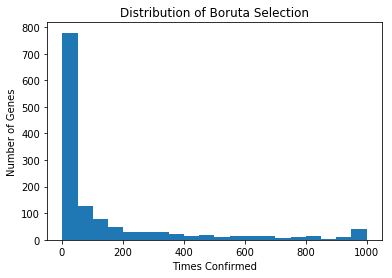

In [93]:
plt.hist(x = boruta.Counts, bins=20)
plt.title('Distribution of Boruta Selection')
plt.xlabel('Times Confirmed')
plt.ylabel('Number of Genes');

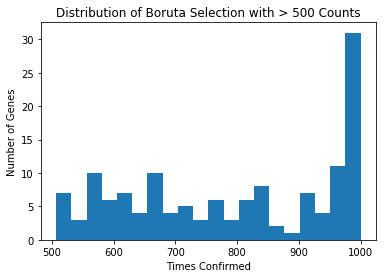

In [94]:
plt.hist(x = boruta[boruta.Counts > 500]['Counts'], bins=20)
plt.title('Distribution of Boruta Selection with > 500 Counts')
plt.xlabel('Times Confirmed')
plt.ylabel('Number of Genes');

In [539]:
boruta_10 = boruta[boruta.Counts == 1000]


,Gene Name,Counts
5,ENSG00000170893.3,1000
8,ENSG00000137449.14,1000
23,ENSG00000078399.14,1000
28,ENSG00000139117.12,1000
42,ENSG00000253293.4,1000
54,ENSG00000254369.5,1000
69,ENSG00000105997.21,1000
84,ENSG00000253187.2,1000
105,ENSG00000106006.6,1000
121,ENSG00000105996.6,1000


what would happen if we chose the top 50 genes from here then predicted..

# Final Gene Table

### Round 1 Visualization (train/test)

In [95]:
# set of 34 genes
round_1_important

# 34 genes found important by all three models
round_1_df.head()

,Genes,Lasso Weights,XGB Feature Importance
23,ENSG00000120833.12,-0.207404,0.002494
29,ENSG00000225872.2,-0.177139,0.003741
3,ENSG00000214145.5,-0.162696,0.000623
31,ENSG00000203799.9,-0.151181,0.001247
17,ENSG00000271952.1,-0.123135,0.002494


In [96]:
model_performance

,Model,Log Loss Performance,Number of Weighted Features
0,Lasso Regression,0.169,88
1,Random Forest,0.297,1649
2,XGBoost,0.188,241


### Round 2 Visualization (kfold)

- no intersection between the three models with kfold

In [97]:
kfold_model_performance

,Model,Log Loss Performance,KFold Features
0,Lasso Regression,0.251,23
1,Random Forest,0.297,971
2,XGBoost,0.282,8


In [98]:
def dict_weight_helper(d, x):
    """
    inputs
    -----
    d: dictionary
    x: value
    
    outputs
    ------
    new value into dataframe if it exists in dictionary
    """
    if x not in d:
        return 0.0
    else:
        return d[x]

def kfold_dataframe_edits(df, dict_list):
    """
    inputs
    -----
    df
    dict_list
    -----
    outputs
    -----
    df with new columns
    """
    names = ['Lasso KF', 'XGB KF', 'RF KF']
    i = 0
    for d in dict_list:
        name = names[i]
        w = name + ' Weight'
        df[name] = df['Genes'].apply(lambda x: x in d.keys()).astype(float)
        df[w] = df['Genes'].apply(lambda x: dict_weight_helper(d, x))
        i += 1
#     df['Kfold Sum'] = df['Lasso KF'] + df['XGB KF'] + df['RF KF']
    return df


In [99]:
gc_df = round_1_df.copy()

In [100]:
test_df = kfold_dataframe_edits(gc_df, [lasso_average_weight1, xgbk_average_weight, rfk_average_weight])

In [101]:
test_df.head()

,Genes,Lasso Weights,XGB Feature Importance,Lasso KF,Lasso KF Weight,XGB KF,XGB KF Weight,RF KF,RF KF Weight
23,ENSG00000120833.12,-0.207404,0.002494,1.0,-0.081941,0.0,0.0,1.0,0.000720
29,ENSG00000225872.2,-0.177139,0.003741,0.0,0.000000,0.0,0.0,0.0,0.000000
3,ENSG00000214145.5,-0.162696,0.000623,0.0,0.000000,0.0,0.0,1.0,0.000509
31,ENSG00000203799.9,-0.151181,0.001247,0.0,0.000000,0.0,0.0,0.0,0.000000
17,ENSG00000271952.1,-0.123135,0.002494,0.0,0.000000,0.0,0.0,0.0,0.000000


In [102]:
# dictionaries of the genes and weights
lasso_average_weight1

xgbk_average_weight

rfk_average_weight

print('These are dictionaries')

These are dictionaries


### Round 3 (Boruta 1 Round)

In [103]:
rf_boruta_features

print('These are 1 round Boruta features')

These are 1 round Boruta features


In [104]:
def dataframe_boruta_editor(df, boruta_features):
    df['Boruta'] = df['Genes'].apply(lambda x: x in boruta_features).astype(float)
    return df

In [106]:
t2 = dataframe_boruta_editor(test_df, rf_boruta_features)
t2.head()

,Genes,Lasso Weights,XGB Feature Importance,Lasso KF,Lasso KF Weight,XGB KF,XGB KF Weight,RF KF,RF KF Weight,Boruta
23,ENSG00000120833.12,-0.207404,0.002494,1.0,-0.081941,0.0,0.0,1.0,0.000720,0.0
29,ENSG00000225872.2,-0.177139,0.003741,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,ENSG00000214145.5,-0.162696,0.000623,0.0,0.000000,0.0,0.0,1.0,0.000509,0.0
31,ENSG00000203799.9,-0.151181,0.001247,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
17,ENSG00000271952.1,-0.123135,0.002494,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


### Round 4 (Boruta 10000 Rounds)

In [107]:
boruta.head()

,Genes,Counts
0,ENSG00000129194.6,951
1,ENSG00000172236.15,995
2,ENSG00000196557.9,997
3,ENSG00000163106.9,999
4,ENSG00000134569.8,994


In [111]:
t2.sort_values('Boruta', ascending=False).head()

,Genes,Lasso Weights,XGB Feature Importance,Lasso KF,Lasso KF Weight,XGB KF,XGB KF Weight,RF KF,RF KF Weight,Boruta
15,ENSG00000260182.1,-0.036433,0.012469,0.0,0.000000,0.0,0.000000,1.0,0.006698,1.0
32,ENSG00000250696.4,-0.061263,0.006234,0.0,0.000000,1.0,0.009096,1.0,0.002818,1.0
11,ENSG00000078399.14,0.117808,0.009975,1.0,-0.165946,0.0,0.000000,1.0,0.008296,1.0
13,ENSG00000267453.5,0.055393,0.000623,0.0,0.000000,0.0,0.000000,1.0,0.006032,1.0
0,ENSG00000136040.7,0.016051,0.046758,0.0,0.000000,0.0,0.000000,1.0,0.007670,1.0


In [112]:
test_merge = pd.merge(t2, boruta, how='left', on='Genes')
test_merge.head()

,Genes,Lasso Weights,XGB Feature Importance,Lasso KF,Lasso KF Weight,XGB KF,XGB KF Weight,RF KF,RF KF Weight,Boruta,Counts
0,ENSG00000120833.12,-0.207404,0.002494,1.0,-0.081941,0.0,0.0,1.0,0.000720,0.0,457.0
1,ENSG00000225872.2,-0.177139,0.003741,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN
2,ENSG00000214145.5,-0.162696,0.000623,0.0,0.000000,0.0,0.0,1.0,0.000509,0.0,559.0
3,ENSG00000203799.9,-0.151181,0.001247,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,62.0
4,ENSG00000271952.1,-0.123135,0.002494,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,14.0


In [127]:
def final_counts(df):
    df['Bootstrap Boruta'] = df['Counts'].notnull()
    df['Total'] = df['Lasso KF'] + df['XGB KF'] + df['RF KF'] + df['Boruta'] + df['Bootstrap Boruta']
    df['Absolute Weights'] = df['Lasso Weights'].apply(lambda x: np.abs(x))
    return df

In [128]:
final_df = final_counts(test_merge)

In [129]:
final_df.sort_values('Total', ascending=False, inplace=True)
final_df.head(10)

,Genes,Lasso Weights,XGB Feature Importance,Lasso KF,Lasso KF Weight,XGB KF,XGB KF Weight,RF KF,RF KF Weight,Boruta,Counts,Bootstrap Boruta,Total,Abs Lasso Weight,Absolute Weights
32,ENSG00000078399.14,0.117808,0.009975,1.0,-0.165946,0.0,0.000000,1.0,0.008296,1.0,1000.0,True,4.0,0.117808,0.117808
11,ENSG00000250696.4,-0.061263,0.006234,0.0,0.000000,1.0,0.009096,1.0,0.002818,1.0,968.0,True,4.0,0.061263,0.061263
16,ENSG00000213759.7,-0.044974,0.000623,0.0,0.000000,1.0,0.006449,1.0,0.002952,1.0,909.0,True,4.0,0.044974,0.044974
23,ENSG00000188626.6,0.002879,0.000623,1.0,-0.107721,0.0,0.000000,1.0,0.003689,1.0,961.0,True,4.0,0.002879,0.002879
33,ENSG00000172236.15,0.197125,0.003117,0.0,0.000000,0.0,0.000000,1.0,0.005126,1.0,995.0,True,3.0,0.197125,0.197125
25,ENSG00000197992.5,0.016430,0.001247,1.0,-0.078128,0.0,0.000000,1.0,0.000797,0.0,288.0,True,3.0,0.016430,0.016430
8,ENSG00000165300.7,-0.084024,0.025561,0.0,0.000000,0.0,0.000000,1.0,0.000794,1.0,866.0,True,3.0,0.084024,0.084024
24,ENSG00000136040.7,0.016051,0.046758,0.0,0.000000,0.0,0.000000,1.0,0.007670,1.0,918.0,True,3.0,0.016051,0.016051
15,ENSG00000232431.3,-0.047662,0.000623,0.0,0.000000,0.0,0.000000,1.0,0.004439,1.0,904.0,True,3.0,0.047662,0.047662
29,ENSG00000156535.12,0.049265,0.001247,1.0,-0.056539,0.0,0.000000,1.0,0.000178,0.0,12.0,True,3.0,0.049265,0.049265


In [130]:
comparison_df = final_df.loc[:, ['Genes', 'Lasso Weights', 'Absolute Weights', 'Counts', 'Total']]

In [131]:
comparison_df.head()

,Genes,Lasso Weights,Absolute Weights,Counts,Total
32,ENSG00000078399.14,0.117808,0.117808,1000.0,4.0
11,ENSG00000250696.4,-0.061263,0.061263,968.0,4.0
16,ENSG00000213759.7,-0.044974,0.044974,909.0,4.0
23,ENSG00000188626.6,0.002879,0.002879,961.0,4.0
33,ENSG00000172236.15,0.197125,0.197125,995.0,3.0


In [134]:
comparison_df.sort_values('Counts', ascending=False).head(10)

,Genes,Lasso Weights,Absolute Weights,Counts,Total
32,ENSG00000078399.14,0.117808,0.117808,1000.0,4.0
30,ENSG00000267453.5,0.055393,0.055393,997.0,3.0
33,ENSG00000172236.15,0.197125,0.197125,995.0,3.0
12,ENSG00000248334.5,-0.061208,0.061208,995.0,3.0
17,ENSG00000260182.1,-0.036433,0.036433,993.0,3.0
22,ENSG00000230453.8,-0.000015,0.000015,988.0,3.0
11,ENSG00000250696.4,-0.061263,0.061263,968.0,4.0
23,ENSG00000188626.6,0.002879,0.002879,961.0,4.0
24,ENSG00000136040.7,0.016051,0.016051,918.0,3.0
16,ENSG00000213759.7,-0.044974,0.044974,909.0,4.0


In [135]:
comparison_df.sort_values('Absolute Weights', ascending=False).head(10)

,Genes,Lasso Weights,Absolute Weights,Counts,Total
0,ENSG00000120833.12,-0.207404,0.207404,457.0,3.0
33,ENSG00000172236.15,0.197125,0.197125,995.0,3.0
1,ENSG00000225872.2,-0.177139,0.177139,NaN,0.0
2,ENSG00000214145.5,-0.162696,0.162696,559.0,2.0
3,ENSG00000203799.9,-0.151181,0.151181,62.0,1.0
4,ENSG00000271952.1,-0.123135,0.123135,14.0,1.0
5,ENSG00000165092.11,-0.118801,0.118801,312.0,2.0
32,ENSG00000078399.14,0.117808,0.117808,1000.0,4.0
6,ENSG00000232629.7,-0.095294,0.095294,31.0,1.0
7,ENSG00000183837.9,-0.088655,0.088655,372.0,2.0
